## Model Selection
The analysis below is based on a reduced set of dummy journeys. The use of the reduced set was to avoid delays in testing the differnt models, when the final set is trained it will be done on the entire set of data available. 

A series of models were chosen for analysis for various reasons; simplicity, use/success in previous research or because they are highly praised in contemporary study. Regression models were used as we are looking to estimate a continuous value of journey time rather than a categorical value like early/late.

As a base model, the simple linear regression model was evaluated, while this may be seen as too simple to fit the appearantly complex nature of travel time prediction, we can see from the initial graphical analysis that the distance travelled and number of stops vs the target of journey time follows a linear increasing path although it has large standard deviation in places. 

Next K Nearest Neighbours was tested, this model has been noted in previous research as being potentially useful but may be quite sensitive to selections of K and thefore may not generalise well to new data. Support vector regression was also tested again due to its frequent appearance in research on travel time prediction.

Following the analysis of these models the error term of Mean Absolute Error was still too high and we began to explore ensemble methods. Random Forest was first investigated as it was expected the use of multiple models to provide a best estimate answere would be better than any of the single models implemented previously. The model was more succesful but there still appeared to be too large an error term. As a final attempt, the Extreme Gradient Boost model was applied. This has not been used often in the research we have seen possibly due to the difficulty it has in working with time series data. The data we use however is not time series in nature and so should not fall prey to these issues. 

The most successful model employed was XGB and this was used for the training of the full set of predicition models in production.

The models were analysed on three components, Mean Absolute Error (minutes), Mean Absolute Percentage Error and Mean Absolute Error by Distance (minutes/km). The MAE and MAPE are standard error estimates in research and have been employed in many previous research we have investigated. The use of MAED was seen to be a more useful estimate as the distance of the different trips can vary broadly.

In [1]:
import pandas as pd
import numpy as np
import datetime
import sklearn
import pickle

# Sklearn tools
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from sklearn.model_selection import KFold
from scipy.stats import chi2_contingency
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVR
from matplotlib.backends.backend_pdf import PdfPages



# Charting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages


# hide ipykernel warnings 
import warnings
warnings.filterwarnings('ignore')

#Plotting inline
%matplotlib inline

In [2]:
# Read in the cleaned csv generated by the analysis file
df = pd.read_csv(r'Data\dummy_journeys.csv', keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)

### Understanding Model Data

In [3]:
results_chart = df.copy()
results_chart = results_chart[results_chart['LINEID'] == "122"]
results_chart["dist_rounded"] = round(results_chart["DIST_BETWEEN"]/500)*500
results_chart["stops_rounded"] = round(results_chart["STOPS_BETWEEN"]/5)*5
results_chart.head()

,Unnamed: 0,WEEKDAY,LINEID,HOUR,ROUTEID,DIRECTION,DIST_BETWEEN,STOPS_BETWEEN,temp,weather_main,JOURNEY_TIME,dist_rounded,stops_rounded
305,611,Monday,122,08:00:00,122_16,2.0,6153.0,20.0,8.01,Drizzle,1068.0,6000.0,20.0
306,613,Monday,122,08:00:00,122_16,2.0,7989.0,25.0,8.01,Drizzle,3283.0,8000.0,25.0
307,614,Monday,122,08:00:00,122_16,2.0,5923.0,20.0,8.01,Drizzle,2814.0,6000.0,20.0
308,616,Monday,122,08:00:00,122_16,2.0,864.0,3.0,8.01,Drizzle,109.0,1000.0,5.0
309,619,Monday,122,08:00:00,122_16,2.0,2964.0,11.0,8.01,Drizzle,1418.0,3000.0,10.0


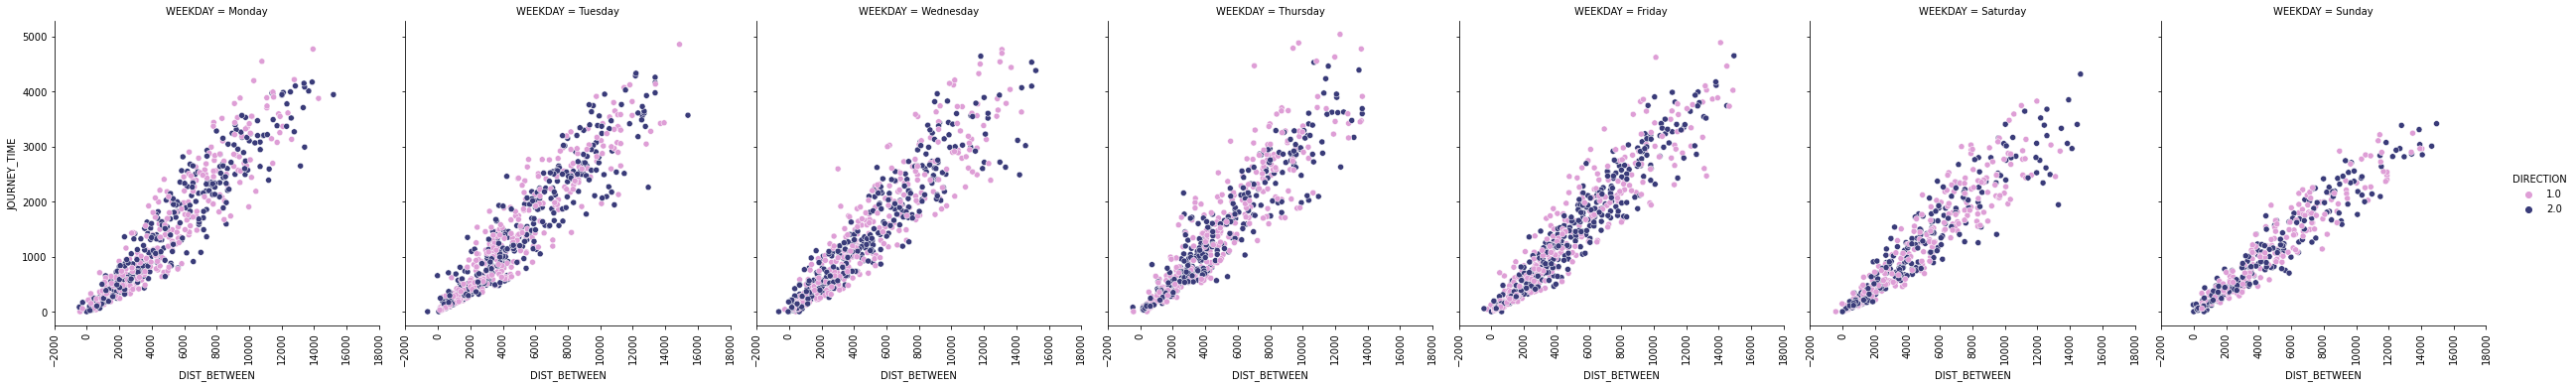

In [5]:
results_chart["DIST_BETWEEN"] = pd.Categorical(results_chart["DIST_BETWEEN"], categories=sorted(set(results_chart["DIST_BETWEEN"])), ordered=True)
g = sns.relplot(data=results_chart, x="DIST_BETWEEN", y="JOURNEY_TIME", hue="DIRECTION",  col="WEEKDAY", height=5, palette='tab20b_r')

g.set_xticklabels(rotation=90)

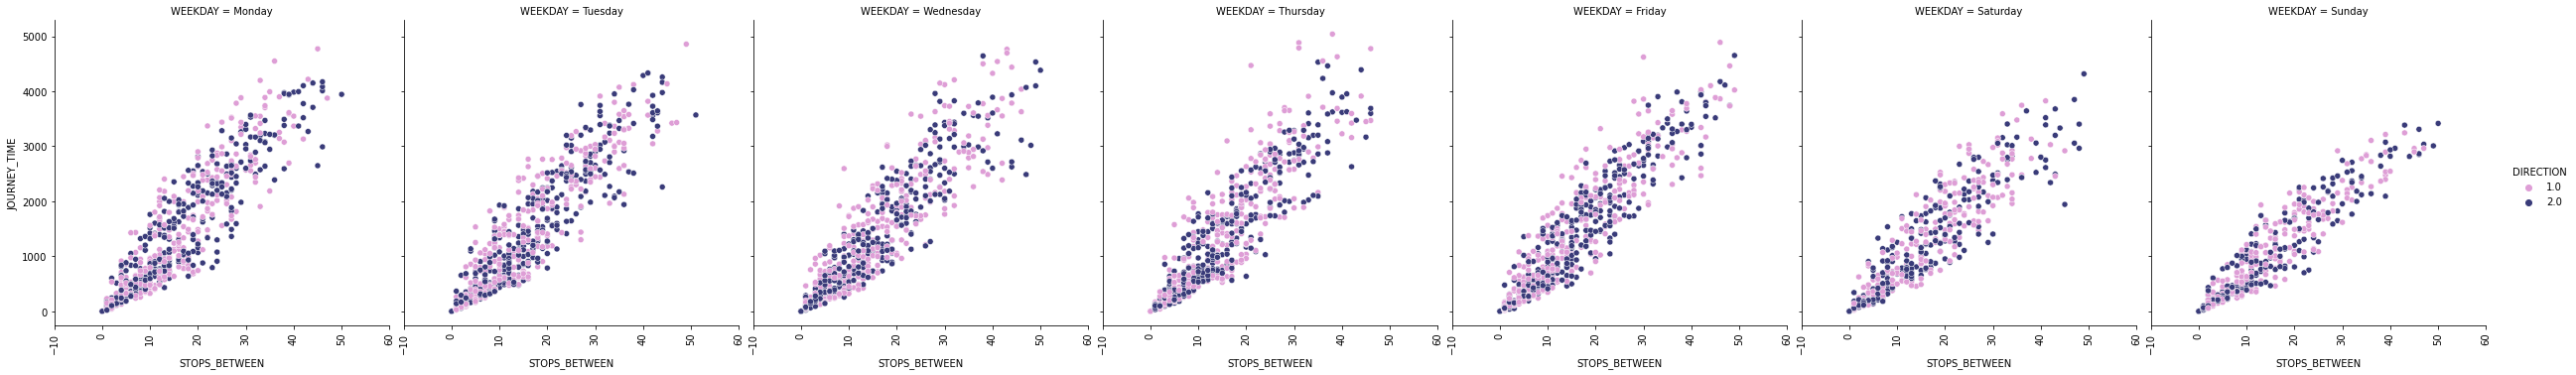

In [6]:
results_chart["STOPS_BETWEEN"] = pd.Categorical(results_chart["STOPS_BETWEEN"], categories=sorted(set(results_chart["STOPS_BETWEEN"])), ordered=True)
g = sns.relplot(data=results_chart, x="STOPS_BETWEEN", y="JOURNEY_TIME", hue="DIRECTION",  col="WEEKDAY", height=5, palette='tab20b_r')

g.set_xticklabels(rotation=90)

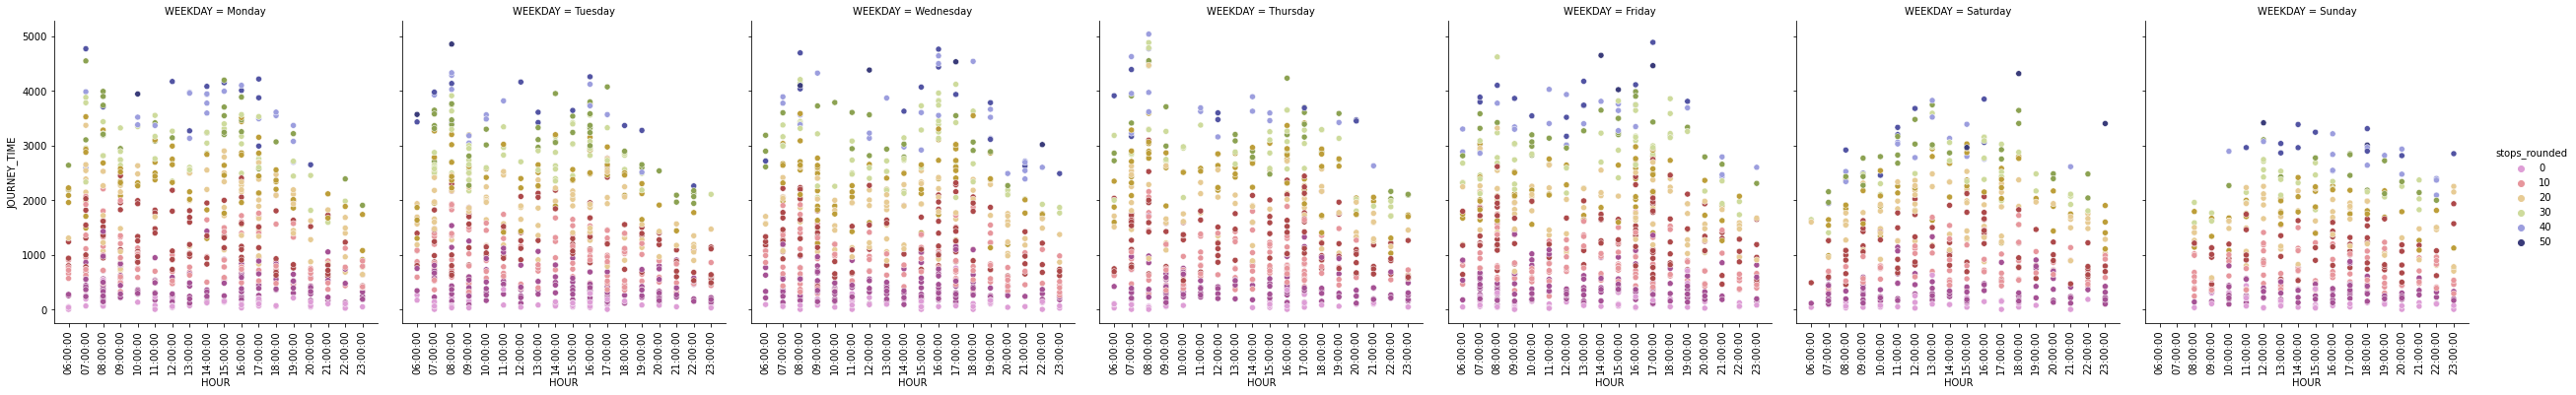

In [8]:
results_chart["HOUR"] = pd.Categorical(results_chart["HOUR"], categories=sorted(set(results_chart["HOUR"])), ordered=True)
g = sns.relplot(data=results_chart, x="HOUR", y="JOURNEY_TIME", hue="stops_rounded",  col="WEEKDAY", height=5, palette='tab20b_r')

g.set_xticklabels(rotation=90)

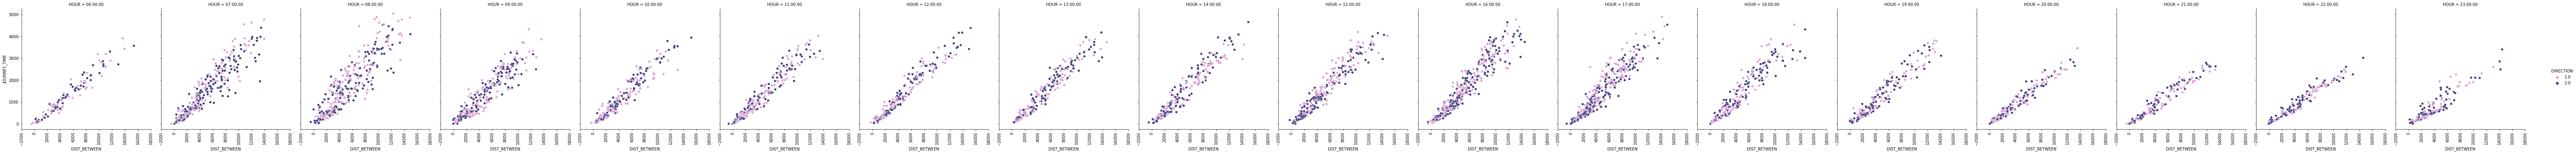

In [10]:
# Slope angle looks to be approximately the same until about 8pm or so
results_chart["DIST_BETWEEN"] = pd.Categorical(results_chart["DIST_BETWEEN"], categories=sorted(set(results_chart["DIST_BETWEEN"])), ordered=True)
g = sns.relplot(data=results_chart, x="DIST_BETWEEN", y="JOURNEY_TIME", hue="DIRECTION",  col="HOUR", height=5, palette='tab20b_r')

g.set_xticklabels(rotation=90)

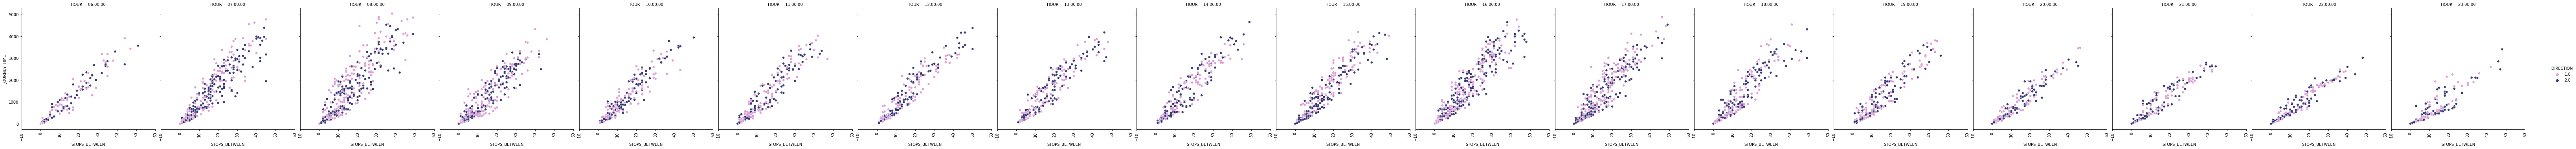

In [11]:
# Slope angle looks to be approximately the same until about 8pm or so but this may just be related to the 
results_chart["STOPS_BETWEEN"] = pd.Categorical(results_chart["STOPS_BETWEEN"], categories=sorted(set(results_chart["STOPS_BETWEEN"])), ordered=True)
g = sns.relplot(data=results_chart, x="STOPS_BETWEEN", y="JOURNEY_TIME", hue="DIRECTION",  col="HOUR", height=5, palette='tab20b_r')

g.set_xticklabels(rotation=90)

### Prepare Data

In [12]:
# Drop ROUTEID which has string characters
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.drop(['ROUTEID'], axis=1, inplace=True)

# Drop negative distances and zero stop journeys
df = df[df['DIST_BETWEEN'] > 1]  
df = df[df['STOPS_BETWEEN'] > 1] 
route_filter = "46A"
df = df[df['LINEID'] == route_filter]

In [13]:
# set up dummies features
df = pd.get_dummies(df, columns=['WEEKDAY', 'DIRECTION', 'HOUR', 'LINEID', 'weather_main'], 
                    prefix = ['WEEKDAY', 'DIRECTION', 'HOUR', 'LINEID', 'weather_main'], drop_first=True)

In [14]:
# y is target feature
# x is remaining data
y = pd.DataFrame(df["JOURNEY_TIME"])
X = df.drop(["JOURNEY_TIME"],1)

In [15]:
# Scaling test
col_names = ['DIST_BETWEEN', 'STOPS_BETWEEN', 'temp']
features = X[col_names]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
X[col_names] = features

In [16]:
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("original range is: ",df.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])


original range is:  7490
training range (70%):	 rows 0 to 5243
test range (30%): 	 rows 5243 to 7490


In [17]:
y_test

,JOURNEY_TIME
138804,831.0
123108,1317.0
84463,2489.0
155903,503.0
11583,1215.0
...,...
29831,912.0
127158,2611.0
167833,2117.0
83009,2726.0


In [18]:
# Reset index in case they get out of line
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(5)

,DIST_BETWEEN,STOPS_BETWEEN,temp,WEEKDAY_Monday,WEEKDAY_Saturday,WEEKDAY_Sunday,WEEKDAY_Thursday,WEEKDAY_Tuesday,WEEKDAY_Wednesday,DIRECTION_2.0,...,HOUR_17:00:00,HOUR_18:00:00,HOUR_19:00:00,HOUR_20:00:00,HOUR_21:00:00,HOUR_22:00:00,HOUR_23:00:00,weather_main_Drizzle,weather_main_Rain,weather_main_Snow
0,0.333402,0.586207,0.371477,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0.069653,0.051724,0.252775,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0.339001,0.551724,0.658412,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
3,0.130951,0.172414,0.333049,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.168592,0.224138,0.292058,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Linear Regression

Standard linear regression. No hyperparameters exist in vanilla LR so this is just run as is and used as a base model.

In [19]:
# Train multiple linear regression on training set
multiple_linreg = LinearRegression().fit(X_train, y_train)

In [20]:
# Coefficients are nested inside a list, this extracts them one layer
coefficients = [item for sublist in multiple_linreg.coef_ for item in sublist]

In [21]:
# Print the weights learned for each feature.
df_feat_coef = pd.DataFrame(list(zip(X_train.columns, coefficients)))

In [22]:
df_feat_coef = df_feat_coef.rename(columns={0: 'Feature', 1: 'Coeficient'})
print("\nIntercept is: \n", multiple_linreg.intercept_)
df_feat_coef.sort_values(by='Coeficient', ascending=False)


Intercept is: 
 [140.32918156]


,Feature,Coeficient
1,STOPS_BETWEEN,4358.141615
20,HOUR_16:00:00,383.914293
21,HOUR_17:00:00,362.011102
11,HOUR_07:00:00,271.949036
12,HOUR_08:00:00,268.880503
19,HOUR_15:00:00,266.015232
18,HOUR_14:00:00,221.217480
16,HOUR_12:00:00,207.586523
17,HOUR_13:00:00,182.511051
22,HOUR_18:00:00,155.907252


In [23]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_train = multiple_linreg.predict(X_train)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_train, pd.DataFrame(multiple_linreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(10))


Predictions with multiple linear regression: 

   JOURNEY_TIME    Predicted
0        2347.0  2779.710013
1         448.0   380.264936
2        1325.0  2305.720328
3         635.0   962.388656
4        1272.0  1484.510879
5         707.0   236.486155
6         333.0   169.674962
7         974.0  1002.853944
8        1846.0  2590.362247
9         939.0  1014.500422


#### Cross Validation

In [24]:
def cross_val_LinReg(X, y, cv=3, scoring='accuracy'):
    """Functions to carry out cross validation on the linear regression model
    Default number of validations is 3. The randon state will be updated 
    at each iteration to allow our results to be repeated"""
    
    # store results
    data = []
    results = []
    
    # evaluate cv times and append to results
    for i in range(cv):
        
        # set up train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        
        # generate model
        multiple_linreg = LinearRegression().fit(X_train, y_train)
        
        # threshold
        multiple_linreg_predictions = multiple_linreg.predict(X_test)
        
        # calc score
        if scoring=='MAE':
            score = metrics.mean_absolute_error(y_test, multiple_linreg_predictions)
        elif scoring=='MAPE':
            score = metrics.mean_absolute_percentage_error(y_test, multiple_linreg_predictions)
        elif scoring=='MAED':
            # This should give minutes per kilometer
            score = (metrics.mean_absolute_error(y_test, multiple_linreg_predictions) / sum(X_test['DIST_BETWEEN']/1000)) * 60 

        elif scoring=='R2':
            score = metrics.r2_score(y_test, multiple_linreg_predictions)


        
        # append to results
        results.append(score)
    return results

In [25]:
def cross_val_LinReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    linRegResults = {}
    # metrics to test against
    #test_metrics = ['MAE', 'MSE','MAPE', 'R2']
    test_metrics = ['MAE', 'MAPE', 'MAED']
    
    for metric in test_metrics:
        
        # generate test results
        result = cross_val_LinReg(X, y, cv=10, scoring=metric)
        length = len(result)
        
        # store result in dict
        linRegResults[metric] = sum(result)/length

    # create dataframe with results
    LinRegDF = pd.DataFrame.from_dict(linRegResults, orient='index', columns=['Linear_Regression'])
    
    return LinRegDF

In [26]:
linRegDF = cross_val_LinReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
linRegDF

Mean results from 10 fold cross validation are:


,Linear_Regression
MAE,302.562554
MAPE,0.375967
MAED,40255.618298


### KNN

KNN has two main hyperparameters that we will look to tune. Number of near neighbours and weighting. We begin by applying the vanilla KNN to get a baseline score and then adjust the hyperparameters to see what kind of improvement can be found. 

In adjusting the number of neighbours, we look to min the mean absolute error. This is run twice, once with each weighting (distance or uniform). Once calculated the optimal parameters are passed to the model.

In [27]:
# Fitting regressor to the Training set
knn_regressor = KNeighborsRegressor()
knn_regressor.fit(X_train, y_train)

KNeighborsRegressor()

In [28]:
# calculate the prediction and threshold the value. If >= 0.5 its true
knn_regressor_predictions_train = knn_regressor.predict(X_test)

print("\nPredictions with KNN regression: \n")
actual_vs_predicted_knn_regressor = pd.concat([y_test, pd.DataFrame(knn_regressor_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_knn_regressor.head(10))


Predictions with KNN regression: 

   JOURNEY_TIME  Predicted
0         831.0     1174.8
1        1317.0     2004.2
2        2489.0     1719.0
3         503.0      376.2
4        1215.0     1278.2
5          85.0      212.6
6         354.0      399.0
7         358.0      688.8
8         476.0      459.4
9        1995.0     1637.0


#### After Optimisation

In [29]:
# Fitting regressor to the Training set
knn_regressor = KNeighborsRegressor(n_neighbors = 2, weights='distance')
knn_regressor.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=2, weights='distance')

In [30]:

knn_regressor_predictions_train = knn_regressor.predict(X_test)

print("\nPredictions with KNN regression: \n")
actual_vs_predicted_knn_regressor = pd.concat([y_test, pd.DataFrame(knn_regressor_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_knn_regressor.head(10))


Predictions with KNN regression: 

   JOURNEY_TIME    Predicted
0         831.0  1539.471745
1        1317.0  1838.272013
2        2489.0  1881.567709
3         503.0   251.230888
4        1215.0   917.737726
5          85.0   164.260868
6         354.0   135.286164
7         358.0   350.376341
8         476.0   629.595750
9        1995.0  2003.569720


#### Cross Validation

In [31]:
def cross_val_KNN(X, y, cv=3, scoring='accuracy'):
    """Functions to carry out cross validation on the linear regression model
    Default number of validations is 3. The randon state will be updated 
    at each iteration to allow our results to be repeated"""
    
    # store results
    results = []
    
    # evaluate cv times and append to results
    for i in range(cv):
        
        # set up train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        
        sc = MinMaxScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        
        # generate model
        knn = KNeighborsRegressor(n_neighbors = 2, weights='distance').fit(X_train, y_train)
        
        # threshold
        knn_predictions = knn.predict(X_test)
        
        # calc score
        if scoring=='MAE':
            score = metrics.mean_absolute_error(y_test, knn_predictions)
        elif scoring=='MAPE':
            score = metrics.mean_absolute_percentage_error(y_test, knn_predictions)
        elif scoring=='MAED':
            score = metrics.mean_absolute_error(y_test, knn_predictions)
        elif scoring=='R2':
            score = metrics.r2_score(y_test, knn_predictions)


        
        # append to results
        results.append(score)
    return results

In [32]:
from sklearn.preprocessing import MinMaxScaler

def cross_val_KNN_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    KNNResults = {}
    # metrics to test against
    test_metrics = ['MAE', 'MAPE']
    
    for metric in test_metrics:
        
        # generate test results
        result = cross_val_KNN(X, y, cv=10, scoring=metric)
        length = len(result)
        
        # store result in dict
        KNNResults[metric] = sum(result)/length

    # create dataframe with results
    KNNDF = pd.DataFrame.from_dict(KNNResults, orient='index', columns=['KNN_Regression'])
    
    return KNNDF

In [33]:
KNNDF = cross_val_KNN_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
KNNDF

Mean results from 10 fold cross validation are:


,KNN_Regression
MAE,344.583899
MAPE,0.358262


#### Optimisation

In [34]:
# Update with gridsearch CV
# https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a
# https://colab.research.google.com/github/dlsun/pods/blob/master/05-Regression-Models/5.6%20Model%20Selection%20and%20Hyperparameter%20Tuning.ipynb#scrollTo=v0qX7lJURC6C

In [35]:
# Set default model to adjust
knn_model = KNeighborsRegressor(n_neighbors=3, weights='uniform')

In [36]:
# GridSearchCV will replace n_neighbors and weights by values in param_grid
grid_search = GridSearchCV(knn_model,
                           param_grid={"n_neighbors": range(1, 10), "weights": ["distance", "uniform"]},
                           scoring="neg_mean_absolute_error",
                           cv=10)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(n_neighbors=3),
             param_grid={'n_neighbors': range(1, 10),
                         'weights': ['distance', 'uniform']},
             scoring='neg_mean_absolute_error')

In [37]:
# calculate estimate of test error for a value of k
# Based on Kaggle example - https://www.kaggle.com/melihkanbay/knn-best-parameters-gridsearchcv
# Look to min the neg_mean_absolute_error

def get_cv_error(k):
  # define pipeline
  pipeline = make_pipeline(
      #StandardScaler(), # Data is already scaled
      KNeighborsRegressor(n_neighbors=k, weights='distance')
  ) 
  # calculate errors from cross-validation
  cv_errs = -cross_val_score(pipeline, X=X_train, y=y_train,
                             scoring="neg_mean_absolute_error", cv=10)
  # calculate average of the cross-validation errors
  return cv_errs.mean()
    
ks = pd.Series(range(1, 20))
ks.index = range(1, 20)
test_errs = ks.apply(get_cv_error)


KNeighborsRegressor(n_neighbors=3, weights='distance')

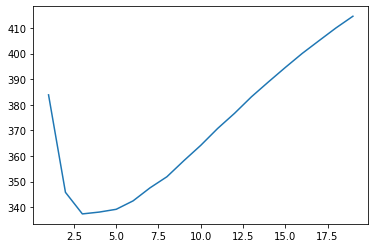

In [38]:
# Combine results of analysis
test_errs.plot.line()
test_errs.sort_values()

grid_search.best_estimator_

### SVR

In [39]:
# https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/`

In [40]:
svm_reg = SVR()
svm_reg.fit(X_train, y_train)

SVR()

In [41]:
# calculate the prediction and threshold the value. If >= 0.5 its true
SVR_regressor_predictions_train = svm_reg.predict(X_test)

print("\nPredictions with SVR regression: \n")
actual_vs_predicted_SVR_regressor = pd.concat([y_test, pd.DataFrame(SVR_regressor_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_SVR_regressor.head(10))


Predictions with SVR regression: 

   JOURNEY_TIME    Predicted
0         831.0  1222.612122
1        1317.0  1292.471844
2        2489.0  1275.319595
3         503.0  1224.528876
4        1215.0  1249.343599
5          85.0  1205.857268
6         354.0  1218.984098
7         358.0  1231.957946
8         476.0  1231.283631
9        1995.0  1264.078862


#### Optimised

In [42]:
svm_lin_reg = SVR(kernel='linear', C=1000)
svm_lin_reg.fit(X_train, y_train)

SVR(C=1000, kernel='linear')

In [43]:
# calculate the prediction and threshold the value. If >= 0.5 its true
SVR_regressor_predictions_train = svm_lin_reg.predict(X_test)

print("\nPredictions with SVR regression: \n")
actual_vs_predicted_SVR_regressor = pd.concat([y_test, pd.DataFrame(SVR_regressor_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_SVR_regressor.head(10))


Predictions with SVR regression: 

   JOURNEY_TIME    Predicted
0         831.0   998.412812
1        1317.0  2032.279190
2        2489.0  1577.951462
3         503.0   356.282323
4        1215.0  1131.568746
5          85.0    81.187136
6         354.0    70.303703
7         358.0   618.663187
8         476.0   592.432777
9        1995.0  1641.446495


#### Cross Validation

In [44]:
def cross_val_svm(X, y, cv=3, scoring='accuracy'):
    """Functions to carry out cross validation on the linear regression model
    Default number of validations is 3. The randon state will be updated 
    at each iteration to allow our results to be repeated"""
    
    # store results
    results = []
    
    # evaluate cv times and append to results
    for i in range(cv):
        
        # set up train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        
        sc = MinMaxScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        
        # generate model
        svm_model = SVR(kernel='linear', C=1000).fit(X_train, y_train)
        
        # threshold
        svm_predictions = svm_model.predict(X_test)
        
        # calc score
        if scoring=='MAE':
            score = metrics.mean_absolute_error(y_test, svm_predictions)
        elif scoring=='MAPE':
            score = metrics.mean_absolute_percentage_error(y_test, svm_predictions)
        elif scoring=='MAED':
            score = metrics.mean_absolute_error(y_test, svm_predictions)
        elif scoring=='R2':
            score = metrics.r2_score(y_test, svm_predictions)


        
        # append to results
        results.append(score)
    return results

In [45]:
from sklearn.preprocessing import MinMaxScaler

def cross_val_svm_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    svmResults = {}
    
    # metrics to test against
    test_metrics = ['MAE', 'MAPE']
    
    for metric in test_metrics:
        
        # generate test results
        result = cross_val_svm(X, y, cv=10, scoring=metric)
        length = len(result)
        
        # store result in dict
        svmResults[metric] = sum(result)/length

    # create dataframe with results
    svmDF = pd.DataFrame.from_dict(svmResults, orient='index', columns=['SVM_Regression'])
    
    return svmDF

In [46]:
svmDF = cross_val_svm_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
svmDF

Mean results from 10 fold cross validation are:


,SVM_Regression
MAE,292.277471
MAPE,0.296439


#### Optimisation

In [47]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['poly'], 'gamma': [1e-3, 1e-4], 'degree': [2,3,4], 'C': [1, 10, 100, 1000]}]

scores = ['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVR(), tuned_parameters, scoring='%s' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))


# Tuning hyper-parameters for neg_mean_absolute_error

Best parameters set found on development set:

{'C': 1000, 'kernel': 'linear'}

Grid scores on development set:

-871.931 (+/-39.209) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
-872.250 (+/-39.210) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
-868.739 (+/-39.206) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
-871.930 (+/-39.209) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
-837.267 (+/-39.092) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
-868.724 (+/-39.206) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
-568.525 (+/-33.730) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
-837.120 (+/-39.091) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
-705.643 (+/-36.679) for {'C': 1, 'kernel': 'linear'}
-324.714 (+/-14.369) for {'C': 10, 'kernel': 'linear'}
-299.826 (+/-12.999) for {'C': 100, 'kernel': 'linear'}
-297.775 (+/-11.953) for {'C': 1000, 'kernel': 'linear'}
-872.108 (+/-39.209) for {'C': 1, 'gamma': 0.001, 'kernel'

### Random Forest

#### First Look at Tree

In [48]:
dtc = DecisionTreeRegressor(max_depth=3, random_state=1)
dtc.fit(X_train, y_train)

print("Max depth 3: \n",dtc)

Max depth 3: 
 DecisionTreeRegressor(max_depth=3, random_state=1)


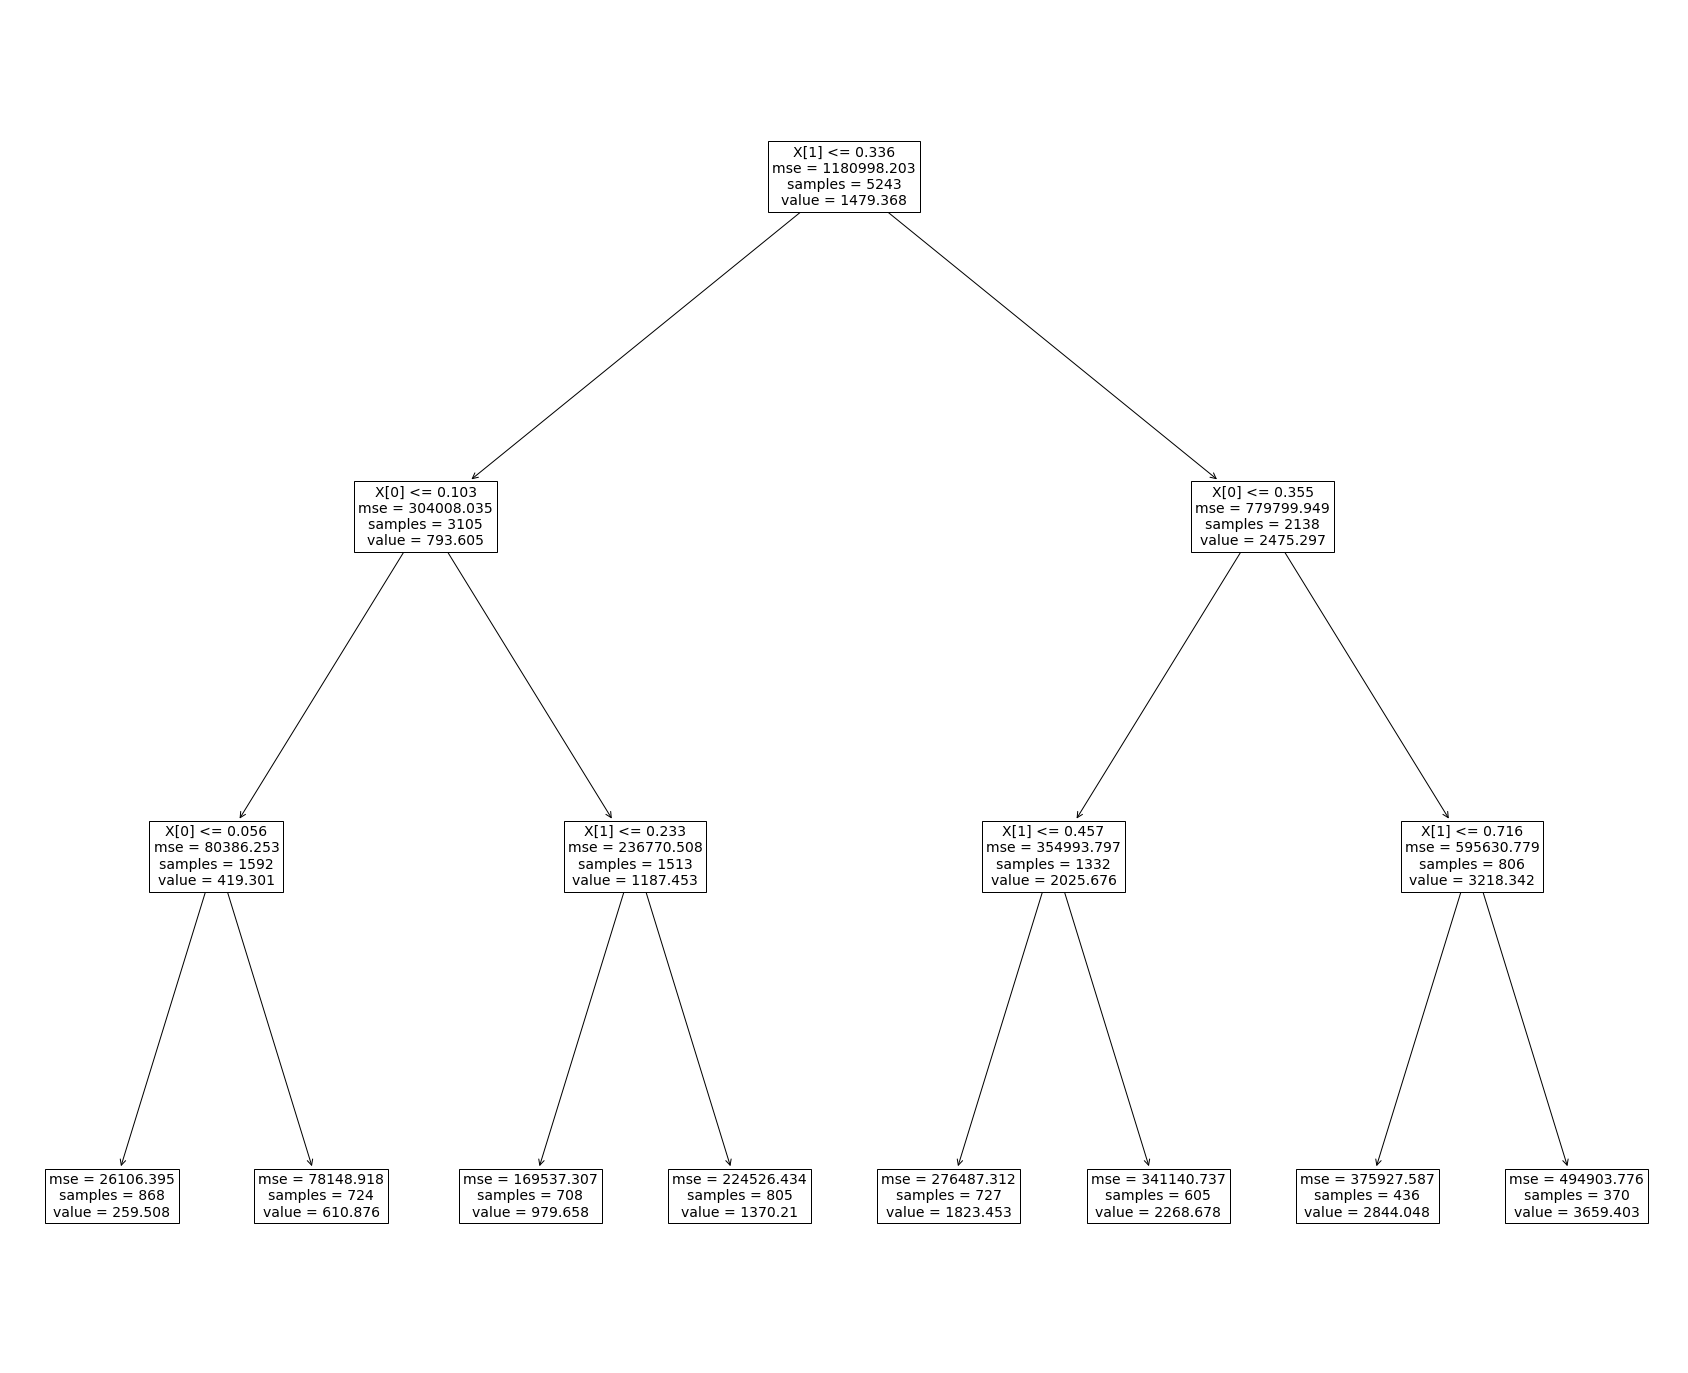

In [49]:
# plot tree
plt.figure(figsize=(30,25))  # set plot size
sklearn.tree.plot_tree(dtc, fontsize=14)
plt.show()

In [50]:
# create a Graphviz png
with open("DecisionTree.dot", 'w') as f1:
    f1 = export_graphviz(dtc, out_file=f1, feature_names=X_train.columns)

!dot -Tpng DecisionTree.dot -o DecisionTree.png

#### Now Look at Forest

In [51]:
# Train RF with 100 trees
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [52]:
# calculate the prediction and threshold the value. If >= 0.5 its true
rf_regressor_predictions_train = rfr.predict(X_test)

print("\nPredictions with RF regression: \n")
actual_vs_predicted_rf_regressor = pd.concat([y_test, pd.DataFrame(rf_regressor_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_rf_regressor.head(10))


Predictions with RF regression: 

   JOURNEY_TIME    Predicted
0         831.0  1337.830000
1        1317.0  1966.180000
2        2489.0  1800.370000
3         503.0   461.580000
4        1215.0  1344.240000
5          85.0   145.540000
6         354.0   269.720667
7         358.0   566.300000
8         476.0   585.260000
9        1995.0  1563.770000


#### Optimised

In [53]:
# Train RF with 100 trees
rfr = RandomForestRegressor(max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=6, n_estimators=200)
rfr.fit(X_train, y_train)
model = rfr.fit(X_train, y_train)

In [54]:
# calculate the prediction and threshold the value. If >= 0.5 its true
rf_regressor_predictions_train = rfr.predict(X_test)

print("\nPredictions with RF regression: \n")
actual_vs_predicted_rf_regressor = pd.concat([y_test, pd.DataFrame(rf_regressor_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_rf_regressor.head(10))


Predictions with RF regression: 

   JOURNEY_TIME    Predicted
0         831.0  1153.491562
1        1317.0  1931.794149
2        2489.0  1840.631912
3         503.0   381.942735
4        1215.0  1281.756494
5          85.0   157.596616
6         354.0   241.714728
7         358.0   636.644669
8         476.0   624.273888
9        1995.0  1726.722165


In [55]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfr.feature_importances_})
importance.sort_values('importance', ascending=False)

,feature,importance
1,STOPS_BETWEEN,0.515259
0,DIST_BETWEEN,0.399270
2,temp,0.019553
27,HOUR_23:00:00,0.007350
26,HOUR_22:00:00,0.005710
20,HOUR_16:00:00,0.005186
9,DIRECTION_2.0,0.004688
25,HOUR_21:00:00,0.004607
5,WEEKDAY_Sunday,0.003972
21,HOUR_17:00:00,0.003207


#### Cross Validation

In [56]:
def cross_val_rf(X, y, cv=3, scoring='accuracy'):
    """Functions to carry out cross validation on the linear regression model
    Default number of validations is 3. The randon state will be updated 
    at each iteration to allow our results to be repeated"""
    
    # store results
    results = []
    
    # evaluate cv times and append to results
    for i in range(cv):
        
        # set up train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        
        sc = MinMaxScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        
        # generate model
        #rf_model = RandomForestRegressor(max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=6, n_estimators=200).fit(X_train, y_train)
        rf_model = RandomForestRegressor(max_features='sqrt', min_samples_split=10).fit(X_train, y_train)
        
        # threshold
        rf_predictions = rf_model.predict(X_test)
        
        # calc score
        if scoring=='MAE':
            score = metrics.mean_absolute_error(y_test, rf_predictions)
        elif scoring=='MAPE':
            score = metrics.mean_absolute_percentage_error(y_test, rf_predictions)
        elif scoring=='MAED':
            score = metrics.mean_absolute_error(y_test, rf_predictions)
        elif scoring=='R2':
            score = metrics.r2_score(y_test, rf_predictions)


        
        # append to results
        results.append(score)
    return results

In [57]:
from sklearn.preprocessing import MinMaxScaler

def cross_val_rf_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    rfResults = {}
    
    # metrics to test against
    test_metrics = ['MAE', 'MAPE']
    
    for metric in test_metrics:
        
        # generate test results
        result = cross_val_rf(X, y, cv=10, scoring=metric)
        length = len(result)
        
        # store result in dict
        rfResults[metric] = sum(result)/length

    # create dataframe with results
    rfDF = pd.DataFrame.from_dict(rfResults, orient='index', columns=['RF_Regression'])
    
    return rfDF

In [58]:
rfDF = cross_val_rf_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
rfDF

Mean results from 10 fold cross validation are:


,RF_Regression
MAE,275.151925
MAPE,0.308833


#### Optimisation

In [59]:
# https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/random_forest_explained/Improving%20Random%20Forest%20Part%202.ipynb

In [60]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'criterion' : ['mae'],
    'max_depth': [None, 5, 10, 25],
    'max_features': [1, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 50, 100, 500],
    'min_samples_split': [1, 10, 50, 100],
    'n_estimators': [10, 50, 100]
}

In [61]:
# Create a base model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [62]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_
{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}

best_grid = grid_search.best_estimator_

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


In [63]:
best_grid

RandomForestRegressor(criterion='mae', max_features='sqrt',
                      min_samples_split=10)

In [64]:
# Train RF with 100 trees
rfr = best_grid
rfr.fit(X_train, y_train)
model = rfr.fit(X_train, y_train)

In [65]:
# calculate the prediction and threshold the value. If >= 0.5 its true
rf_regressor_predictions_train = rfr.predict(X_test)

print("\nPredictions with RF regression: \n")
actual_vs_predicted_rf_regressor = pd.concat([y_test, pd.DataFrame(rf_regressor_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_rf_regressor.head(10))


Predictions with RF regression: 

   JOURNEY_TIME  Predicted
0         831.0   1150.050
1        1317.0   1888.605
2        2489.0   1596.070
3         503.0    338.975
4        1215.0   1158.735
5          85.0    209.260
6         354.0    271.785
7         358.0    654.495
8         476.0    680.530
9        1995.0   1856.200


### XG Boost

In [96]:
# Train GB
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

GradientBoostingRegressor()

In [97]:
# calculate the prediction and threshold the value. If >= 0.5 its true
gb_regressor_predictions_train = gbr.predict(X_test)

print("\nPredictions with GB regression: \n")
actual_vs_predicted_gb_regressor = pd.concat([y_test, pd.DataFrame(rf_regressor_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_gb_regressor.head(10))


Predictions with GB regression: 

   JOURNEY_TIME    Predicted
0         831.0  1115.525445
1        1317.0  1954.777201
2        2489.0  2115.564011
3         503.0   475.846558
4        1215.0  1287.063845
5          85.0   111.101596
6         354.0   203.320598
7         358.0   674.250996
8         476.0   636.686106
9        1995.0  1677.975111


### Optimised

In [100]:
# Train GB
gbr = GradientBoostingRegressor(n_estimators=1000)
gbr.fit(X_train, y_train)
model = gbr.fit(X_train, y_train)

In [101]:
gb_regressor_predictions_train = gbr.predict(X_test)

print("\nPredictions with GB regression: \n")
actual_vs_predicted_gb_regressor = pd.concat([y_test, pd.DataFrame(gb_regressor_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_gb_regressor.head(10))


Predictions with GB regression: 

   JOURNEY_TIME    Predicted
0         831.0  1115.525445
1        1317.0  1954.777201
2        2489.0  2115.564011
3         503.0   475.846558
4        1215.0  1287.063845
5          85.0   111.101596
6         354.0   203.320598
7         358.0   674.250996
8         476.0   636.686106
9        1995.0  1677.975111


#### Cross Validation

In [105]:
def cross_val_gb(X, y, cv=3, scoring='accuracy'):
    """Functions to carry out cross validation on the linear regression model
    Default number of validations is 3. The randon state will be updated 
    at each iteration to allow our results to be repeated"""
    
    # store results
    results = []
    
    # evaluate cv times and append to results
    for i in range(cv):
        
        # set up train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        
        sc = MinMaxScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        
        # generate model
        gb_model = GradientBoostingRegressor(n_estimators=1000, max_depth=5).fit(X_train, y_train)
        
        # threshold
        gb_predictions = gb_model.predict(X_test)
        
        # calc score
        if scoring=='MAE':
            score = metrics.mean_absolute_error(y_test, gb_predictions)
        elif scoring=='MAPE':
            score = metrics.mean_absolute_percentage_error(y_test, gb_predictions)
        elif scoring=='MAED':
            score = metrics.mean_absolute_error(y_test, gb_predictions)
        elif scoring=='R2':
            score = metrics.r2_score(y_test, gb_predictions)


        
        # append to results
        results.append(score)
    return results

In [106]:
from sklearn.preprocessing import MinMaxScaler

def cross_val_gb_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    gbResults = {}
    
    # metrics to test against
    test_metrics = ['MAE', 'MAPE']
    
    for metric in test_metrics:
        
        # generate test results
        result = cross_val_gb(X, y, cv=10, scoring=metric)
        length = len(result)
        
        # store result in dict
        gbResults[metric] = sum(result)/length

    # create dataframe with results
    gbDF = pd.DataFrame.from_dict(gbResults, orient='index', columns=['GB_Regression'])
    
    return gbDF

In [107]:
gbDF = cross_val_gb_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
gbDF

Mean results from 10 fold cross validation are:


,GB_Regression
MAE,252.873915
MAPE,0.245270


#### Optimisation

In [66]:
# Create the parameter grid based on the results of random search 
param_grid = {
    "n_estimators":[10, 100, 250, 1000],
    "max_depth":[1,3,5,10],
    "learning_rate":[0.01,0.1,1,10,100]}


In [67]:
# Create a base model
gbr = GradientBoostingRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = gbr, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2, scoring='neg_mean_absolute_error')

In [68]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_
{   
    "n_estimators":5,
    "max_depth":1,
    "learning_rate":0.01}

best_grid = grid_search.best_estimator_

Fitting 3 folds for each of 80 candidates, totalling 240 fits


In [69]:
best_grid

GradientBoostingRegressor(n_estimators=1000)